In [1]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()

if jpt_in_notebook():
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3,4,5'

/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')


In [2]:
from functools import partial
import os
import sys
import numpy as np

import pickle
from tqdm import tqdm 

import torch
from torch.utils.data import DataLoader

from datasets import load_dataset

import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import DataCollatorForSeq2Seq

from open_instruct.finetune_trainer import encode_with_prompt_completion_format, encode_with_messages_format

import sys
sys.path.insert(0, "/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/fast-map-dpp")
from dpp import dpp


[2023-09-21 14:36:21,907] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [16]:
model_name_or_path = '../results/baselines/huggyllama/llama-7b'

train_file = '../data/processed/all.jsonl'
train_file = '../data/processed/flan_v2/flan_v2_data.jsonl'


save_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts'
save_path = os.path.join(save_dir, 'note_explore_dpp_llama-7b_flan_v2_outputs.pkl')
gen_embeddings = False

In [17]:

data_files = {'train': train_file}
raw_datasets = load_dataset("json", data_files=data_files)
print(len(raw_datasets['train']))


Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-0fa1872b4ac9a29f/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

100000


In [5]:

model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path,
    device_map='auto',
    torch_dtype=torch.float16)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)
tokenizer.padding_side = 'left'
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id


Using pad_token, but it is not set yet.


In [7]:
encode_function = partial(
    encode_with_messages_format,
    tokenizer=tokenizer,
    max_seq_length=2048,
)

lm_datasets = raw_datasets.map(
    encode_function,
    batched=False,
    num_proc=16,
    desc="Tokenizing and reformatting instruction data",
)

train_dataset = lm_datasets['train']

train_dataset.set_format(type="torch", 
                         output_all_columns=False, 
                         columns=['input_ids', 'labels', 'attention_mask'])
train_dataset

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-0fa1872b4ac9a29f/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-3a8173652244b47d_*_of_00016.arrow


Dataset({
    features: ['dataset', 'id', 'messages', 'input_ids', 'labels', 'attention_mask'],
    num_rows: 100000
})

In [8]:


# collate_fn = DataCollatorForSeq2Seq(tokenizer=tokenizer, padding='longest') 

loader = DataLoader(train_dataset, shuffle=False, batch_size=1) 


In [ ]:
if gen_embeddings:

    device = 'cuda'

    text_embeddings = []
    log_probs = []

    for batch in tqdm(loader, total=len(loader)):
        batch = {k: v.to('cuda', non_blocking=True) for k, v in batch.items()}
        input_ids = batch['input_ids']

        with torch.inference_mode():
            outputs = model(**batch, output_hidden_states=True)

        # (bsz, seq_len, hidden_size) -> (bsz, hidden_size)
        text_embedding = outputs['hidden_states'][-1].mean(1)

        # sum of output token log probs
        log_prob = -outputs['loss']

        text_embeddings.append(text_embedding.detach().cpu().numpy())
        log_probs.append(log_prob.detach().cpu().numpy())

In [18]:
if gen_embeddings:
    d = {'text_embeddings': np.vstack(text_embeddings),
         'log_probs': np.vstack(log_probs)}

    with open(save_path, 'wb') as f:
        pickle.dump(d, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(save_path, 'rb') as f:
        d = pickle.load(f)

In [19]:
N = 100
M = 10

In [9]:
# some entries are nan.
d['log_probs'] = np.nan_to_num(d['log_probs'], nan=np.nanmean(d['log_probs']))

text_embeddings = d['text_embeddings'][:N,:]
log_probs = d['log_probs'][:N,:].squeeze()

Text(0, 0.5, 'log P_LM(Seq)')

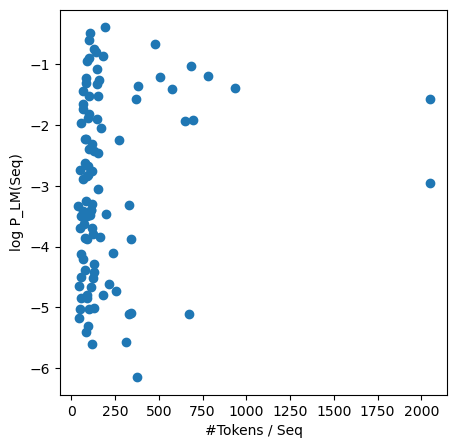

In [20]:
# get an idea of log-prob vs. length. see if there is bias & need to normalize by length.
# - no obvious correlation between #tokens/seq and log P_LM(seq).
# - true larger number of tokens, the log probability is larger

num_tokens = []
for i in range(N):
    n = len(train_dataset[i]['input_ids'])
    num_tokens.append(n)

fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(num_tokens, log_probs)
ax.set_xlabel('#Tokens / Seq')
ax.set_ylabel('log P_LM(Seq)')
# ax.set_xlim((0,250))

In [21]:
## what are low/high p_LM(seq) examples?
#  - low: input prompt has excotic knowledge, or need to come up with exotic knowledge in the answer.
#  - high: output already exists in the input prompt (copy 1 sentence, remove punctuation, summarization)

K = 10
inds = np.argsort(log_probs)
inds = inds[-K:] # top k
inds = inds[:K]  # bot k

for k in range(K):
    ind = int(inds[k])
    print('\n'+'==='*20+f' k={k},ind={str(ind)},logprob={log_probs[ind]:.3f}')
    print(tokenizer.decode(train_dataset[ind]['input_ids']))


============================================================ k=0,ind=1,logprob=-1.022
<s> <|user|>
Answer by taking a quote from the following article:

Tedder was born the son of Sir Arthur John Tedder and Emily Charlotte Tedder (nee Bryson) at the Glenguin Distillery (now Glengoyne) in the Campsie Fells, north of Glasgow. His father was distinguished as the Commissioner of the Board of Customs who devised the old age pension scheme. His father's occupation meant that the young Tedder saw different parts of the British Isles, spending 1895 to 1898 in Lerwick on the Shetland Isles and 1899-1901 in Elgin, in the County of Moray. In 1902 the family moved to Croydon in Surrey and Tedder attended the Whitgift School until 1909, when he went up to the University of Cambridge.

Tedder was promoted to lieutenant in the Dorset Regiment on 14 October 1914, and arrived back in Britain in December. He was posted to a reserve unit at Wyke Regis on the Dorset coast where he seriously injured his k

In [41]:
text_embeddings /= np.linalg.norm(text_embeddings, axis=-1, keepdims=True)
similarities = np.dot(text_embeddings, text_embeddings.T) # cosine sim
probs = np.exp(log_probs)

K_cos = similarities 
K_cos_prob = probs.reshape(N, 1) * similarities * probs.reshape(1, N)
K_cos_oneminusprob = (1-probs).reshape(N, 1) * similarities * (1-probs).reshape(1, N)

(<Figure size 1500x500 with 6 Axes>, <Axes: >)

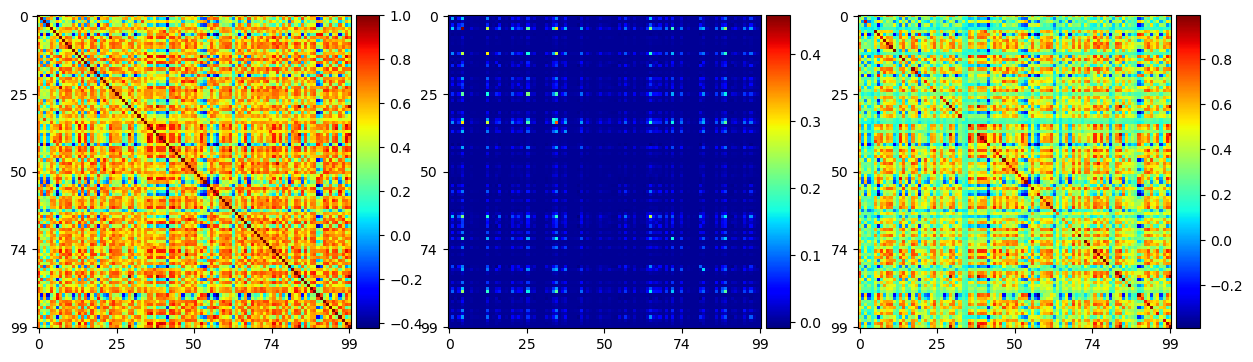

In [42]:
import matplotlib.pyplot as plt
from rosemary import plt_kernel_matrix_one

fig, axs = plt.subplots(1,3,figsize=(15,5))
ax = axs[0]
plt_kernel_matrix_one(fig, ax, K_cos)
ax = axs[1]
plt_kernel_matrix_one(fig, ax, K_cos_prob)
ax = axs[2]
plt_kernel_matrix_one(fig, ax, K_cos_oneminusprob)

In [44]:


out = {}
Ks = {'K_cos': K_cos, 'K_cos_prob': K_cos_prob, 'K_cos_oneminusprob': K_cos_oneminusprob}
pct = [0.05, .1, .2, .5]
for x in pct:
    M = int(x*N)
    for kernel_matrix_name, K in Ks.items():
        print(f'running: {kernel_matrix_name}_M={M}')
        inds = dpp(K, M)
        out[f'{kernel_matrix_name}_M={M}'] = inds
        


{'K_cos_M=5': [5, 31, 62, 2, 28],
 'K_cos_prob_M=5': [4, 34, 64, 25, 33],
 'K_cos_oneminusprob_M=5': [46, 38, 62, 28, 19],
 'K_cos_M=10': [5, 31, 62, 2, 28, 19, 99, 3, 37, 44],
 'K_cos_prob_M=10': [4, 34, 64, 25, 33, 12, 71, 81, 1, 88],
 'K_cos_oneminusprob_M=10': [46, 38, 62, 28, 19, 5, 2, 11, 58, 86],
 'K_cos_M=20': [5,
  31,
  62,
  2,
  28,
  19,
  99,
  3,
  37,
  44,
  86,
  11,
  32,
  58,
  48,
  63,
  41,
  69,
  22,
  12],
 'K_cos_prob_M=20': [4,
  34,
  64,
  25,
  33,
  12,
  71,
  81,
  1,
  88,
  80,
  37,
  96,
  42,
  3,
  20,
  16,
  87,
  74,
  22],
 'K_cos_oneminusprob_M=20': [46,
  38,
  62,
  28,
  19,
  5,
  2,
  11,
  58,
  86,
  32,
  78,
  44,
  53,
  84,
  18,
  79,
  41,
  48,
  63],
 'K_cos_M=50': [5,
  31,
  62,
  2,
  28,
  19,
  99,
  3,
  37,
  44,
  86,
  11,
  32,
  58,
  48,
  63,
  41,
  69,
  22,
  12,
  54,
  20,
  79,
  84,
  18,
  16,
  80,
  71,
  97,
  45,
  4,
  25,
  60,
  30,
  34,
  70,
  1,
  46,
  81,
  23,
  10,
  51,
  57,
  26,
  78,
 

In [45]:
save_path = os.path.join(save_dir, 'note_explore_dpp_llama-7b_flan_v2_subsets.pkl')

with open(save_path, 'wb') as f:
    pickle.dump(out, f, protocol=pickle.HIGHEST_PROTOCOL)

[5, 31, 62, 2, 28]

3.41 ms ± 1.03 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
